# Analysis of frequency-dependent exposure metrics

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import compute_radiation_force, compute_mechanical_index, compute_temperature_increase, pressure_to_intensity, interpolate_at
from usnm2p.fileops import get_data_root
from usnm2p.plotters import *

### Stimulation parameters

In [3]:
# Frequency range (MHz)
fbounds = (0.1, 50.)  # frequency range (MHz)
freqs = np.logspace(*np.log10(np.array(fbounds)), 500)
freqidx = pd.Index(freqs, name='frequency (MHz)')
fhuman_bounds = (0.2, 0.7)  # range of frequencies used in human sutdies (MHz)
fhuman = 0.5  # reference frequency used for human studies (MHz)
fother = np.array([  # list of other frequencies of interest (MHz)
    2.1,  # this work 
    30.  # high-frequency rodent studies 
])

# Stimulation parameters
BD = 0.2  # sonication duration (s)
DC = 0.8  # stimulus duty cycle (-)
P_MPA = P_REF  # reference pressure (MPa)
ISPPA = pressure_to_intensity(P_MPA / PA_TO_MPA) / M2_TO_CM2  # pulse average intensity (W/cm2)
ISPTA = ISPPA * DC  # time-average intensity (W/cm2)
stimlog = '\n'.join(f'  - {s}' for s in [
    f'P = {P_MPA:.2f} MPa',
    f'DC = {DC * 1e2:.0f} %',
    f'duration = {BD:.3f} s',
    f'ISPPA = {ISPPA:.2f} W/cm2',
    f'ISPTA = {ISPTA:.2f} W/cm2',
])
logger.info(f'stimulation parameters:\n{stimlog}')

 2025/10/24 14:11:37: stimulation parameters:
  - P = 0.80 MPa
  - DC = 80 %
  - duration = 0.200 s
  - ISPPA = 19.78 W/cm2
  - ISPTA = 15.83 W/cm2


### Compute exposure metrics over frequency range

In [4]:
# Compute effects across frequencies
logger.info('computing effects across frequency range')
effects = pd.DataFrame({
    'mechanical index (-)': compute_mechanical_index(freqs, P_MPA),
    'radiation force (N/m3)': compute_radiation_force(freqs, ISPPA),
    'temperature increase (°C)': compute_temperature_increase(freqs, ISPTA, BD)
}, index=freqidx)

# Interpolate effects at frequencies of interest
target_effects = interpolate_at(effects, np.hstack([fhuman, fother]))
ref_effects = target_effects.loc[fhuman]
other_effects = target_effects.loc[fother]
logger.info(f'interpolated effects at frequencies of interest:')
target_effects

 2025/10/24 14:11:37: computing effects across frequency range
 2025/10/24 14:11:37: interpolated effects at frequencies of interest:


,mechanical index (-),radiation force (N/m3),temperature increase (°C)
frequency (MHz),,,
0.5,1.131382,707.029195,0.046069
2.1,0.552060,4567.329689,0.297603
30.0,0.146059,144887.814269,9.440767


### Compute dimension ratios over frequency range

In [5]:
# Brain dimensions for mouse and human (in mm)
brain_dims = pd.DataFrame({
    'human': np.array([160, 140, 90]),
    'mouse': np.array([14, 8, 6]),
}, index=['length (mm)', 'width (mm)', 'height (mm)'])

# Compute average brain dimensions
avg_brain_dims = brain_dims.mean().rename('brain dimension (mm)')

# Compute wavelength over frequencies
wvlength = C_BRAIN / freqs * 1e-3  # mm 
whuman = C_BRAIN / fhuman * 1e-3  # mm

# Compute reference dimension ratio of focal size to brain size used in human studies
ref_dim_ratio = whuman / avg_brain_dims['human']
logger.info(f'reference dimension ratio in human studies: {ref_dim_ratio:.3f}')
ref_effects.loc['focal size to brain size'] = ref_dim_ratio

# Compute dimension ratio of focal size to mouse brain size across frequency range
mouse_dim_ratio = pd.Series(
    data=wvlength / avg_brain_dims['mouse'],
    index=freqidx,
)
effects['focal size to brain size'] = mouse_dim_ratio

# Compute frequency at which dimension ratio in mouse would match that seen in human studies
ratio_match_freq = np.interp(
    ref_dim_ratio, mouse_dim_ratio.values[::-1], freqidx[::-1]) 
logger.info(f'frequency at which dimension ratio in mouse would match that seen in human studies')

 2025/10/24 14:11:37: reference dimension ratio in human studies: 0.024
 2025/10/24 14:11:37: frequency at which dimension ratio in mouse would match that seen in human studies


### Plot frequency-dependent trends

 2025/10/24 14:33:01: computing relatiev effects w.r.t. human case
 2025/10/24 14:33:01: plotting frequency dependences
 2025/10/24 14:33:01: relative effects at frequencies of interest:


,mechanical index,radiation force,temperature increase,focal size to brain size
frequency (MHz),,,,
0.5,1.000000,1.000000,1.000000,13.928952
2.1,0.487952,6.459888,6.459888,3.316454
30.0,0.129098,204.924797,204.924797,0.232143


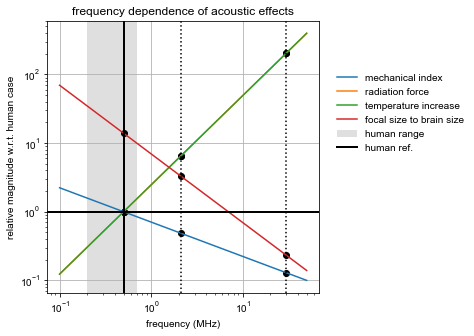

In [15]:
# Compute relative effects w.r.t human case
logger.info('computing relatiev effects w.r.t. human case')
rel_effects = effects / ref_effects
rel_effects.columns = rel_effects.columns.str.split('(').str[0]

# Plot normalized trends
logger.info('plotting frequency dependences')
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_box_aspect(1.)
ax.set_title('frequency dependence of acoustic effects')
ax.set_xscale('log')
ax.set_yscale('log')
rel_effects.plot(ax=ax)
ax.set_ylabel('relative magnitude w.r.t. human case')
ax.grid('on')
ax.axvspan(*fhuman_bounds, fc='silver', ec='none', alpha=0.5, label='human range')
ax.axvline(fhuman, c='k', lw=2, label='human ref.')
ax.legend(loc=(1.05, 0.5), frameon=False)
ax.axhline(1, c='k', lw=2)

# Label characteristic frequencies
ref_rel_effects_dB = interpolate_at(rel_effects, np.hstack([fhuman, fother])) 
for f, dBvals in ref_rel_effects_dB.iterrows():
    ax.axvline(f, ls=':', c='k')
    ax.scatter([f] * len(dBvals), dBvals.values, c='k')
logger.info('relative effects at frequencies of interest:')
ref_rel_effects_dB

### Save figure

In [7]:
figsdir = get_data_root(kind=DataRoot.FIG)
fpath = os.path.join(figsdir, 'exposure_vs_freq.pdf')
fig.savefig(fpath)